In [23]:
import os 
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
def get_clip_info(clip: str) -> list:
    '''
    Returns info on clip. Assumes order of trick_firstname-lastname_sw_slow_mo
    ''' 
    sw = False
    slowmo = False

    clip = clip.split('/')[-1].split('\\')[-1].split('.')[0].split('_')
    trick = clip[0]
    skater = clip[1]
    if len(clip) > 2: 
        if clip[2] == 'sw':
            sw = True
        if clip[2] == 'slow-mo': 
            slowmo = True
        elif len(clip) > 3:
            if clip[3] == 'slow-mo':
                slowmo = True
            

    return [trick, skater, sw, slowmo]

In [34]:
tricks_path = "C:/Users/Braden/Projects/SkateboardAI/skateboard-tricks/"
tricks_data = []

for clip in glob.glob(tricks_path + '/*'): 
#     print(clip)
#     print(get_clip_info(clip))
    entry = get_clip_info(clip)
    entry.append(clip)
    tricks_data.append(entry)      

tricks_data

[['360-flip',
  'akihiko-gatangay',
  False,
  False,
  'C:/Users/Braden/Projects/SkateboardAI/skateboard-tricks\\360-flip_akihiko-gatangay.mov'],
 ['360-flip',
  'andrew-reynolds',
  False,
  False,
  'C:/Users/Braden/Projects/SkateboardAI/skateboard-tricks\\360-flip_andrew-reynolds.mov'],
 ['360-flip',
  'antwuan-dixon',
  False,
  False,
  'C:/Users/Braden/Projects/SkateboardAI/skateboard-tricks\\360-flip_antwuan-dixon.mov'],
 ['360-flip',
  'braden-starcher',
  False,
  False,
  'C:/Users/Braden/Projects/SkateboardAI/skateboard-tricks\\360-flip_braden-starcher.mp4'],
 ['360-flip',
  'braden-starcher',
  False,
  False,
  'C:/Users/Braden/Projects/SkateboardAI/skateboard-tricks\\360-flip_braden-starcher_2.mp4'],
 ['360-flip',
  'hyun-kummer',
  False,
  False,
  'C:/Users/Braden/Projects/SkateboardAI/skateboard-tricks\\360-flip_hyun-kummer.mov'],
 ['360-flip',
  'maurio-mccoy',
  False,
  False,
  'C:/Users/Braden/Projects/SkateboardAI/skateboard-tricks\\360-flip_maurio-mccoy.mov'],

<BarContainer object of 5 artists>

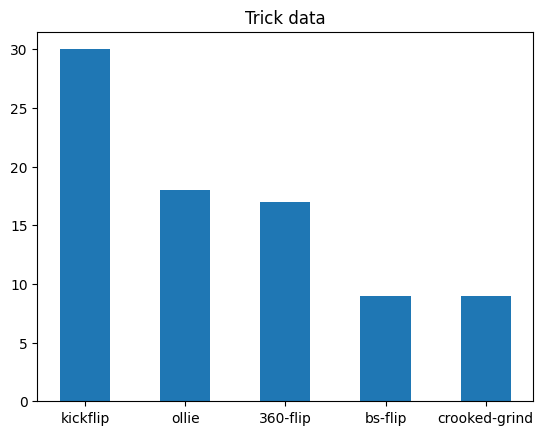

In [48]:
trick_names = ['360-flip', 'crooked-grind' 'bs-flip', 'kickflip','ollie']

tricks_df = pd.DataFrame(tricks_data)
tricks_df = tricks_df.rename(columns={0: 'trick', 1: 'skater', 2: 'switch', 3: 'slowmo', 4: 'filepath'})
# tricks_df
categories = tricks_df['trick'].value_counts().index
counts = tricks_df['trick'].value_counts().values
plt.title("Trick data")
plt.bar(categories, counts, width=0.5)


### SkateboardingDataset

In [11]:
import torch
from skimage import io, transform 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import cv2
import sys

In [170]:
class SkateboardDataset(Dataset): 
    def __init__(self, data_dir, transform=None):
        # parse filenames, store video paths
        self.data_dir = data_dir
        self.transform = transform
        self.video_paths = glob.glob(os.path.join(data_dir, "*"))
        
    def __len__(self): 
        # Return number of videos in dataset
        return len(self.video_paths)
    
    def preprocess_frame(self, frame, target_size=224):
        """Crop and resize frame image"""
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        h, w = frame.shape[:2]
        crop_size = min(h,w)
        start_h = (h - crop_size) // 2
        start_w = (w - crop_size) // 2
        cropped_frame = frame[start_h:start_h+crop_size, start_w:start_w+crop_size]
        resized_frame = cv2.resize(cropped_frame, (224,224))

        return resized_frame
        
    def load_video_frames(self, video_path): 
        
        cap = cv2.VideoCapture(video_path)
        frames = []
        if not cap.isOpened(): 
#             print("Error: could not open video.")
            pass
        else: 
            while cap.isOpened(): 
                ret, frame = cap.read() 
                # if frame is read correctly ret is True 
                if not ret: 
#                     print("Can't receive frame (stream end?). Exiting...")
                    break 
                frame = self.preprocess_frame(frame)
                frames.append(frame)
        cap.release()
        return frames
    
    def __getitem__(self, idx): 
        # load video, sample frames, return (frames, label)
        if torch.is_tensor(idx): 
            idx = idx.tolist()
            
        video_path = video_paths[idx]
        frames = self.load_video_frames(video_path)
        
        label = video_path.split('\\')[-1].split('_')[0]
        
        return torch.tensor(frames), label

In [171]:
data_dir = "C:/Users/Braden/Projects/SkateboardAI/skateboard_dataset"
skate_dataset = SkateboardDataset(data_dir)

print("Found " + str(len(skate_dataset)) + " videos.")

Found 83 videos.


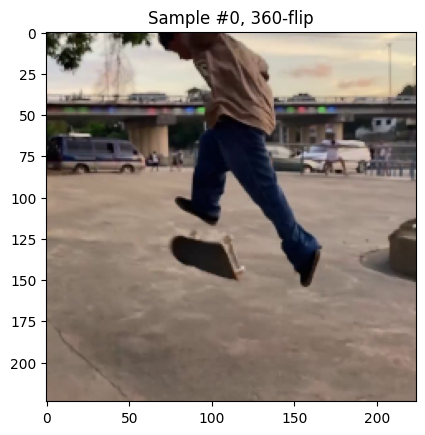

In [174]:
for i , (frames, label) in enumerate(skate_dataset): 
    plt.title("Sample #{}, ".format(i) + label)
    plt.imshow(frames[10].numpy())
    
    if i == 0: break
   
    

In [101]:
video_path = "C:/Users/Braden/Projects/SkateboardAI/skateboard_dataset"
video_paths = glob.glob(os.path.join(video_path, "*"))
video_paths[0].split('\\')[-1].split('_')[0]

'360-flip'

In [78]:
cap = cv2.VideoCapture('./skateboard_dataset/360-flip_akihiko-gatangay.mov')
frames = []
if not cap.isOpened(): 
    print("Error: could not open video.")
else: 
    while cap.isOpened(): 
        ret, frame = cap.read() 
        # if frame is read correctly ret is True 
        if not ret: 
            print("Can't receive frame (stream end?). Exiting...")
            break 
        frames.append(frame)
cap.release()
print(len(frames))

Can't receive frame (stream end?). Exiting...
25


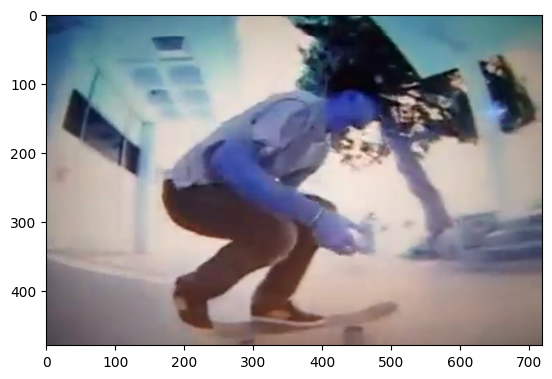

In [128]:
plt.imshow(frames[1])

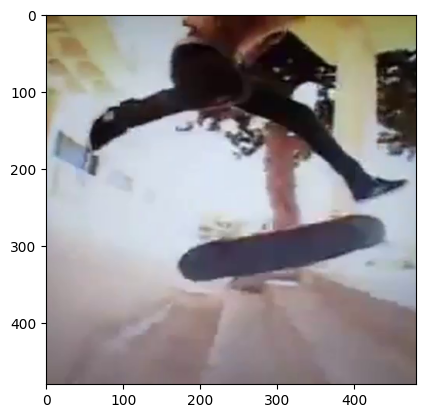

In [132]:
frame = frames[15]
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
h, w = frame.shape[:2]
crop_size = min(h,w)
start_h = (h - crop_size) // 2
start_w = (w - crop_size) // 2
cropped_frame = frame[start_h:start_h+crop_size, start_w:start_w+crop_size]
plt.imshow(cropped_frame)

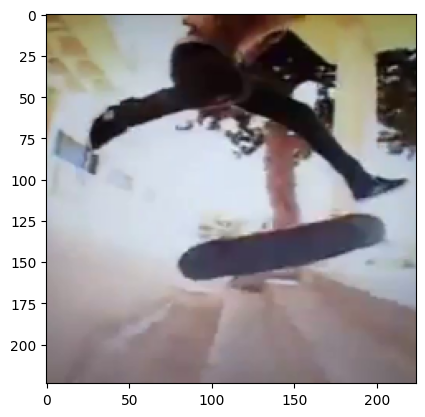

In [135]:
resized_frame = cv2.resize(cropped_frame, (224,224))
plt.imshow(resized_frame)